# Groupe 3
# Presentation Final

|Auteur|Centre|
|---|---|
|ACQUART Quentin|Aix-en-Provence|
|DIMEGLIO Nicolas|Aix-en-Provence|
|SIXDENIER Alexandre|Aix-en-Provence|
|VESSERON Alexandre|Aix-en-Provence|

## Import des différentes bibliothèques

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from skimage.metrics import structural_similarity
from skimage.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio
import os
import collections
import random
import json
from PIL import Image

## Jeux de données

In [3]:
# L1
clean_dataset = "../Dataset/Project_Dataset_Clean"
light_dataset = "../Dataset/Project_Dataset_Test"
image_h = 180
image_w = 180
batch_s = 32

#L2
dataset_path_L2 = "../DatasetL2/Project_Dataset_Unzip/"
image_h_L2 = 320
image_w_L2 = 320
batch_s_L2 = 10

### Livrable 1
L'entreprise veut automatiser la sélection de photos pour l'annotation, le but est de fournir une méthode de classification binaire afin de filtrer les images qui ne sont pas des photos du dataset de départ. Pour ce faire nous allons nous appuyer sur l'architecture des réseaux de neurones, ainsi que l'analyse des résultats obtenus.
Toutes les parties doivent être détaillées dans le notebook :
    - les paramètre du réseau,
    - la fonction de perte ainsi que l'algorithme d'optimisation utilisé pour l’entraînement.

### Analyse à effectuer
- Graphique contenant l'évolution de l'erreur d’entraînement ainsi que de l'erreur de test
- Graphique d'évolution de l'accuracy pour ces deux datasets.

- L'analyse de ces résultats, notamment le compromis entre biais et variance (ou sur-apprentissage et sous-apprentissage).

- Une description des méthodes potentiellement utilisables pour améliorer les compromis biais/variance : technique de régularisation, drop-out, early-stopping, ...

In [4]:
data_dir = clean_dataset
data_dir = pathlib.Path(data_dir)

In [5]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split= 0.20,
  subset = 'training',
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode='rgb',
  label_mode='int',
  labels="inferred"
)

# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split= 0.20,
  subset = 'validation',
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode='rgb',
  label_mode='int',
  labels="inferred"
)

Found 41396 files belonging to 5 classes.
Using 33117 files for training.
Found 41396 files belonging to 5 classes.
Using 8279 files for validation.


In [6]:
new_model = tf.keras.models.load_model('../Projet_Data_Science_G3/model/my_best_model.epoch19-loss0.59.hdf5')
score, accuracy = new_model.evaluate(test_set, batch_size=batch_s)
print('Loss : ', score)
print('Global Accuracy : ', accuracy)

259/259 [==============================] - 13s 35ms/step - loss: 0.5928 - accuracy: 0.8328

### Livrable 2

### Rappel du sujet
Le but est de traiter un ensemble de photographies afin de les rendre mieux traitables par les algorithmes de Machine Learning. Le traitement à réaliser est une opération de débruitage. Nous allons donc produire un notebook Jupyter explicitant ces étapes de prétraitement et leurs performances. Ces algorithmes s'appuieront sur les auto-encodeurs à convolution, et les appliqueront pour améliorer la qualité de l'image.
<br>Toutes les parties doivent être détaillées dans le notebook :

    - Le code de chargement du fichier.

    - Le code du débruitage sur un sous-ensemble d'images bruitées. Le code doit être accompagné d'explications.

    - Une étude de cas.

### Analyse à effectuer

Le but de cette étape va être le suivant :
    Traiter l'ensemble des photographies via un bruitage puis un débruitage à fin d'améliorer leur qualité.
    Le tout à l'aide d'un auto-encodeur à convolution.

In [7]:
def gaussian_noisy(img):
    img_resc = [pix*1./255 for pix in img]
    row,col,ch= img.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = img_resc + gauss
    noisy  = np.clip(noisy, 0., 1.)
    return noisy


normal_datagen = ImageDataGenerator(
        rescale=1./255,
        data_format="channels_last",
        validation_split=0.20
        )
noisy_datagen = ImageDataGenerator(
        preprocessing_function=gaussian_noisy,
        data_format="channels_last",
        validation_split=0.20
        )
train_generator = normal_datagen.flow_from_directory(
        dataset_path_L2,
        subset = 'training',
        target_size=(image_h_L2, image_w_L2),
        batch_size=batch_s_L2,
        shuffle=False,
        class_mode=None,
        )

train_noisy_generator = noisy_datagen.flow_from_directory(
        dataset_path_L2,
        subset = 'training',
        target_size=(image_h_L2, image_w_L2),
        batch_size=batch_s_L2,
        shuffle=False,
        class_mode=None,
        )

test_generator = normal_datagen.flow_from_directory(
        dataset_path_L2,
        subset = 'validation',
        target_size=(image_h_L2, image_w_L2),
        batch_size=batch_s_L2,
        shuffle=False,
        class_mode=None,
        )

test_noisy_generator = noisy_datagen.flow_from_directory(
        dataset_path_L2,
        subset = 'validation',
        target_size=(image_h_L2, image_w_L2),
        batch_size=batch_s_L2,
        shuffle=False,
        class_mode=None,
        )

Found 120 images belonging to 1 classes.
Found 120 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


## Mise en place des itérateurs

In [8]:
train_noisy= train_noisy_generator.next()
test_noisy= test_noisy_generator.next()
train = train_generator.next()
test = test_generator.next()
x_train = train
x_train_noisy = train_noisy
x_test = test
x_test_noisy = test_noisy

In [9]:
def display_single_image(img):
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")

def display_image(X, n):
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(X[i].reshape(image_h_L2, image_w_L2,3))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [10]:
def ssim_score_compare(first_batch_pictures,second_batch_pictures):
    ssim_list_score = []
    for img_first_batch,img_second_batch in zip(first_batch_pictures,second_batch_pictures):
        (score, diff) = structural_similarity(img_first_batch, img_second_batch, multichannel=True, full=True)
        #diff = (diff * 255).astype("uint8")
        ssim_list_score.append(score)
    return ssim_list_score

def mse_score_compare(first_batch_pictures,second_batch_pictures):
    mse_list_score = []
    for img_first_batch,img_second_batch in zip(first_batch_pictures,second_batch_pictures):
        score = mean_squared_error(img_first_batch, img_second_batch)
        mse_list_score.append(score)
    return mse_list_score

def pksnr_score_compare(first_batch_pictures,second_batch_pictures):
    pksnr_list_score = []
    for img_first_batch,img_second_batch in zip(first_batch_pictures,second_batch_pictures):
        score = peak_signal_noise_ratio(img_first_batch, img_second_batch,data_range=1)
        pksnr_list_score.append(score)
    return pksnr_list_score

#### Chargement des meilleurs modèles.

In [11]:
mse_model = tf.keras.models.load_model('../Projet_Data_Science_G3/model/final_train_model.h5')
loss_minimum_model = tf.keras.models.load_model('../Projet_Data_Science_G3/model/L2_model.epoch294-loss0.0147.hdf5')
dssim_model = tf.keras.models.load_model('../Projet_Data_Science_G3/model/final_train_model_DSSIM.h5',compile=False)

full_mse_decoded_img = mse_model.predict(x_test_noisy, verbose=1)
loss_minimum_decoded_img = loss_minimum_model.predict(x_test_noisy, verbose=1)
dssim_decoded_img = dssim_model.predict(x_test_noisy, verbose=1)

1/1 [==============================] - 2s 2s/step


Comparaison des modèles avec score `SSIM`

Image original
Image modèle mse
[0.0572087061706848, 0.061946569423915326, 0.06974644988508129, 0.06913134708076119, 0.07106127513926497, 0.050880135541537475, 0.06303624243684737, 0.049900127581750574, 0.07250281388991207, 0.05199939953126211]
Image modèle loss_minimum
[0.06329860405217931, 0.061420568076696415, 0.0696459290666574, 0.06665986489090435, 0.06806826206581991, 0.050287390714189424, 0.06341425344370179, 0.04821447377621677, 0.07101379768874001, 0.06145639703354492]
Image modèle dssim
[0.5905383617053132, 0.8108488317147007, 0.6271989813427322, 0.7309833451026725, 0.6654173384700064, 0.5810016222350157, 0.7035387819609804, 0.7325922931203439, 0.7466716635483072, 0.711960499824769]


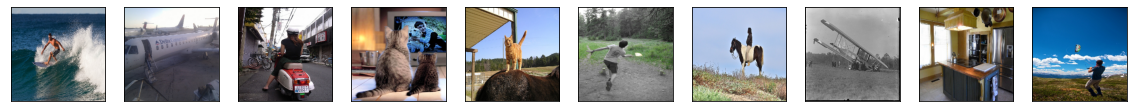

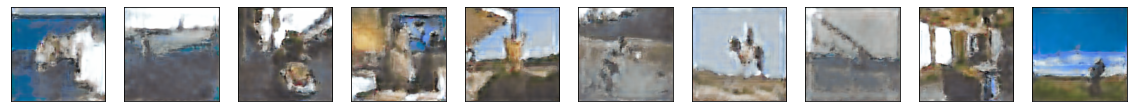

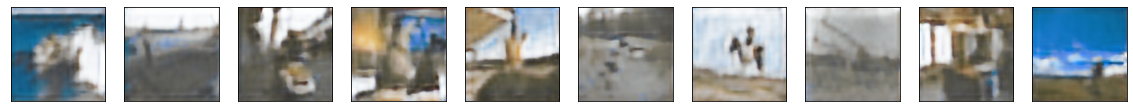

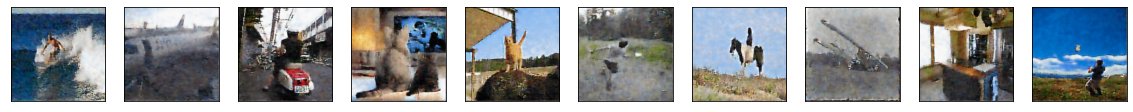

In [12]:
print("Image original")
display_image(x_test,10)
print("Image modèle mse")
print(ssim_score_compare(x_test_noisy,full_mse_decoded_img))
display_image(full_mse_decoded_img,10)
print("Image modèle loss_minimum")
print(ssim_score_compare(x_test_noisy,loss_minimum_decoded_img))
display_image(loss_minimum_decoded_img,10)
print("Image modèle dssim")
print(ssim_score_compare(x_test,dssim_decoded_img))
display_image(dssim_decoded_img,10)

### Livrable 3
### Rappel du sujet
Le but est de créer un réseau de neurones qui génère des légendes pour des images en s'appuyant sur le dataset MS COCO.
Le réseau sera composé de deux parties :
 - la partie CNN qui encode les images en une représentation interne,
 - et la partie RNN utilise cette représentation pour prédire l'annotation séquence par séquence.

Avant l'entraînement du modèle les images sont prétraitées par un CNN pré-entrainé pour la classification.

Le livrable contient :
- Un descriptif sur le pré-traitements d'images et du texte.
- L'architecture complète du réseau utilisé pour le captioning explicitant le type de CNN utilisé pour les prétraitements.
- Une analyse sous forme de courbes des performances du réseau pendant l'entrainement.
- Quelques exemples pour les tests.

### Analyse à effectuer

Le but de cette étape va être le suivant :
- Prétraiter les données
- Classifier les données par un CNN
- Prédire les annotations via un RNN

Afin d'obtenir notre réseau de neurones qui génère des légendes pour des photographies. Nous allons combiner le CNN et le RNN.
Le RNN est branché sur l'avant-dernière couche de notre CNN afin de récupérer le traitement préalablement fait pour effectuer la prédiction d'annotation.